# DATA 607 - Machine Learning

## Class 4 &mdash; 2025.07.09

### Imbalanced classification. Text data.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

#### One more word on overfitting

Training error being significantly smaller than testing error doesn't necessarily mean there's a problem.

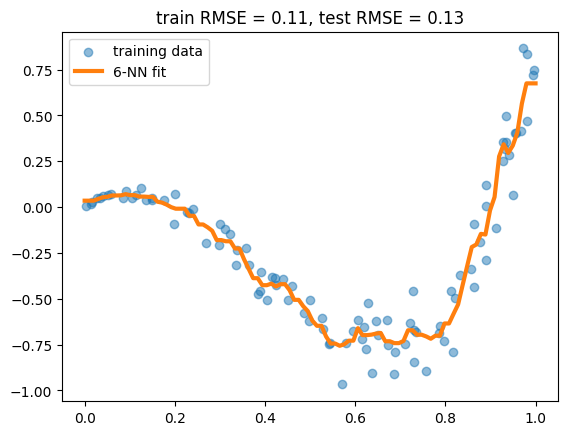

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error


def make_data(n=100, rng=None):
    rng = np.random.default_rng(rng)
    x = rng.uniform(size=n)
    y = 10 * x * (x - 0.2) * (x - 0.9) + 10 * x * 0.02 * rng.normal(size=n)
    return x, y


rng = np.random.default_rng(0)

x_train, y_train = make_data(100, rng=rng)
X_train = x_train.reshape(-1, 1)

x_test, y_test = make_data(10000, rng=rng)
X_test = x_test.reshape(-1, 1)


model = KNeighborsRegressor(n_neighbors=6)
model.fit(X_train, y_train)
train_mse = np.mean(root_mean_squared_error(y_train, model.predict(X_train)))
test_mse = np.mean(root_mean_squared_error(y_test, model.predict(X_test)))

grid = np.linspace(0, 1, 100)
plt.scatter(x_train, y_train, alpha=0.5, label="training data")
plt.plot(grid, model.predict(grid.reshape(-1, 1)), "C1", lw=3, label="6-NN fit")
plt.legend()
plt.title(f"train RMSE = {train_mse:.2f}, test RMSE = {test_mse:.2f}")
plt.show()

#### Imbalanced classification

- When a binary classification dataset is highly imbalanced, say $\mathbb{P}[Y=0]\approx 1$, then the constant classifier $\hat{y}=0$ has accuracy $\approx 1$.

- In these situations, the **false negative rate (FNR)** is $\approx 1$, which is as bad as it can be. Here,
  $$
  \text{FNR} = \mathbb{P}[\hat{y}=0\mid y=1].
  $$

- In typical applications like credit risk, customer retention, information retrieval, fraud detection, or disease screening, this is bad! In such examples, good performance on the minority class is the whole point!

#### Metrics (scores) for imbalanced classification

- **precision**: $\mathbb{P}[y=1\mid\hat{y}=1]$

- **recall**: $\mathbb{P}[\hat{y}=1\mid y=1] = 1 - \text{FNR}$

- **$F_1$**: $\displaystyle\dfrac{1}{\displaystyle\frac12\left(\dfrac1{\text{precision}} + \dfrac1{\text{recall}}\right)}=\dfrac{2\cdot\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}}$

In [5]:
X = pd.read_csv("data/Default.csv")
y = X.pop("default")
X

student      balance        income
0           0   729.526495  44361.625074
1           1   817.180407  12106.134700
2           0  1073.549164  31767.138947
3           0   529.250605  35704.493935
4           0   785.655883  38463.495879
...       ...          ...           ...
9995        0   711.555020  52992.378914
9996        0   757.962918  19660.721768
9997        0   845.411989  58636.156984
9998        0  1569.009053  36669.112365
9999        1   200.922183  16862.952321

[10000 rows x 3 columns]

### 20newsgroups

> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.
>
>  &mdash; [the Scikit Learn docs](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)

- The posts include headers, footers, and quotes. As it turns out, this really helps with classification! We'll work without them, though.

- Since we'll be focusing on model building, we won't touch the test set. We'll draw validation sets from the training data.

In [2]:
# 20newsgroups, a real-world dataset

from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import Bunch


bunch = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
assert isinstance(bunch, Bunch)

X = bunch.data
y = bunch.target

print(f"y[0] = {bunch.target_names[y[0]]}\n\nX[0] = {X[0]}")

y[0] = rec.autos

X[0] = I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [4]:
bunch.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(len(X_train), len(X_test))

5657 5657


## Sparse embeddings with `CountVectorizer`

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer()
counts = counter.fit_transform(X_train)
ic(counts)

print(
    f"proportion of nonzero entries = {len(counts.indices)/(counts.shape[0]*counts.shape[1]):.4f}"
)

ic| counts: <Compressed Sparse Row sparse matrix of dtype 'int64'
            	with 555190 stored elements and shape (5657, 67980)>


proportion of nonzero entries = 0.0014


### `MultinomialNaiveBayes`

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = make_pipeline(CountVectorizer(), MultinomialNB(alpha=1.0))
model.fit(X_train, y_train)
ic(accuracy_score(y_train, model.predict(X_train)))
ic(accuracy_score(y_test, model.predict(X_test)))

ic| accuracy_score(y_train, model.predict(X_train)): 0.7316598904012728
ic| accuracy_score(y_test, model.predict(X_test)): 0.5041541453066997


- Can we improve predictive performance by tuning the `alpha` parameter of the `MultinomialNB` model?

In [ ]:
param_grid = {"multinomialnb__alpha": [0.001, 0.01, 0.1, 1, 10]}
model = make_pipeline(CountVectorizer(), MultinomialNB())
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

ic(search.best_params_)
ic(search.best_score_)
ic(accuracy_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=0.01))])

ic| search.best_params_: {'multinomialnb__alpha': 0.01}
ic| search.best_score_: np.float64(0.6710269219834226)
ic| accuracy_score(y_test, best_model.predict(X_test)): 0.6777443874845325


0.6777443874845325

### Tuning `CountVectorizer` for `MultinomialNaiveBayes`
- `CountVectorizer` also has knobs we can twiddle. See [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for details.

In [ ]:
param_grid = {
    "countvectorizer__stop_words": [None, "english"],
    "countvectorizer__strip_accents": [None, "ascii"],
}
model = make_pipeline(CountVectorizer(), MultinomialNB(alpha=0.01))
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

ic(search.best_params_)
ic(search.best_score_)
ic(accuracy_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB(alpha=0.01))])

ic| search.best_params_: {'countvectorizer__stop_words': 'english',
                          'countvectorizer__strip_accents': None}
ic| search.best_score_: np.float64(0.6724401933308964)
ic| accuracy_score(y_test, best_model.predict(X_test)): 0.6798656531730599


In [ ]:
param_grid = {"countvectorizer__max_df": [0.2, 0.4, 0.6, 0.8, 1.0]}
model = make_pipeline(CountVectorizer(stop_words="english"), MultinomialNB(alpha=0.1))
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

ic(search.best_params_)
ic(search.best_score_)
ic(accuracy_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.2, stop_words='english')),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

ic| search.best_params_: {'countvectorizer__max_df': 0.2}
ic| search.best_score_: np.float64(0.6811007176487864)
ic| accuracy_score(y_test, best_model.predict(X_test)): 0.6855223616757999


##### Exercise

- Can you improve performance by tuning `CountVectorizer`'s `min_df` parameter?

### `LogisticRegression`

In [ ]:
model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), LogisticRegression()
)
model.fit(X_train, y_train)
ic(accuracy_score(y_train, model.predict(X_train)))
ic(accuracy_score(y_test, model.predict(X_test)))

ic| accuracy_score(y_train, model.predict(X_train)): 0.9703022803606152
ic| accuracy_score(y_test, model.predict(X_test)): 0.6558246420364151


In [ ]:
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10]}
model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), LogisticRegression()
)
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

ic(search.best_params_)
ic(search.best_score_)
ic(accuracy_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.2, stop_words='english')),
                ('logisticregression', LogisticRegression(C=0.1))])

ic| search.best_params_: {'logisticregression__C': 0.1}
ic| search.best_score_: np.float64(0.6558252336185808)
ic| accuracy_score(y_test, best_model.predict(X_test)): 0.6648400212126568


### `SGDClassifier`

In [ ]:
from sklearn.linear_model import SGDClassifier

param_grid = {"sgdclassifier__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]}
model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), SGDClassifier()
)
search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_  # returns the best estimator
display(best_model)

ic(search.best_params_)
ic(search.best_score_)
ic(accuracy_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.2, stop_words='english')),
                ('sgdclassifier', SGDClassifier(alpha=0.01))])

ic| search.best_params_: {'sgdclassifier__alpha': 0.01}
ic| search.best_score_: np.float64(0.686936105201001)
ic| accuracy_score(y_test, best_model.predict(X_test)): 0.693477108007778


##### `Normalizer` to normalize rows

- Contrast with `StandardScaler` that operates on columns.

In [18]:
from sklearn.preprocessing import Normalizer

A = np.random.normal(size=(2, 4))

normalizer = Normalizer()

assert np.allclose(
    normalizer.fit_transform(A), A / np.linalg.norm(A, axis=1, keepdims=True)
)

- Default parameter values usually work better with normalized data.

In [ ]:
# Normalize the count data, can use the default value for alpha in SGDClassifier

from sklearn.linear_model import SGDClassifier


model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2), Normalizer(), SGDClassifier()
)
display(model)

model.fit(X_train, y_train)
ic(accuracy_score(y_test, model.predict(X_test)))

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.2, stop_words='english')),
                ('normalizer', Normalizer()),
                ('sgdclassifier', SGDClassifier())])

ic| accuracy_score(y_test, model.predict(X_test)): 0.7035531200282835


### `SVC` (Support Vector Classifier)

In [20]:
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2),
    Normalizer(),  # SVC is sensitive to normalization!
    SVC(kernel="linear", C=1.0),
)

model.fit(X_train, y_train)

ic(accuracy_score(y_test, model.predict(X_test)))

ic| accuracy_score(y_test, model.predict(X_test)): 0.6694360968711331


0.6694360968711331

In [ ]:
from sklearn.svm import LinearSVC

model = make_pipeline(
    CountVectorizer(stop_words="english", max_df=0.2),
    Normalizer(),  # LinearSVC is sensitive to normalization!
    LinearSVC(loss="hinge", max_iter=10000),
)

model.fit(X_train, y_train)

ic(accuracy_score(y_test, model.predict(X_test)))

ic| accuracy_score(y_test, model.predict(X_test)): 0.7037298921689942


### IDF (Inverse Document Frequency) weighting

- Words that apear in lots of documents, are "less informative".

- ***Document frequency*** of the term $t$:
  $$
  \begin{aligned}
  \operatorname{df}(t) &= \text{proportion of documents containing $t$}
  \end{aligned}
  $$

- ***Inverse document frequency*** of the term $t$:
  $$
  \operatorname{idf}(t) = \log\frac1{\operatorname{df}(t)}
  $$
  Even though it's not reflected in the name, the logarithmic scaling is standard.

- Scikit Learn does some extra smoothing by default, so these aren't the exact quantities it computes.

### `TfidfVectorizer`

- Weights each term-count by the corresponding inverse document frequency.

- Concretely, `TfidfVectorizer` multiplies the $j$-th column of the count matrix returned by `CountVectorizer.transform` by the inverse document frequency of the $j$-th term. Each row of the resulting matrix is then normalized to have length $1$.

- This is a bit trick in practice because of *sparse matrices*, but here it is explicitly:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

count_vectorizer = CountVectorizer().fit(X_train)
counts = count_vectorizer.transform(X_train)

tfidf_vectorizer = TfidfVectorizer().fit(X_train)
assert tfidf_vectorizer.vocabulary_ == count_vectorizer.vocabulary_


document_indices, term_indices = counts.nonzero()
smoothed_counts = counts.astype(float)
idf_weights = tfidf_vectorizer.idf_[term_indices]
smoothed_counts.data *= idf_weights

assert np.allclose(
    normalize(smoothed_counts).data, tfidf_vectorizer.transform(X_train).data
)
assert np.all(
    normalize(smoothed_counts).indices == tfidf_vectorizer.transform(X_train).indices
)

- Let's try it out with `LinearSVC`

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer


model = make_pipeline(
    TfidfVectorizer(stop_words="english"),
    LinearSVC(loss="hinge", max_iter=10000),
)

model.fit(X_train, y_train)

ic(accuracy_score(y_test, model.predict(X_test)))

ic| accuracy_score(y_test, model.predict(X_test)): 0.7382004596075659


### Back to `MultinomialNaiveBayes`

In [ ]:
model = make_pipeline(
    TfidfVectorizer(
        stop_words="english"
    ),  # Try letting stop_words revert to the default!
    MultinomialNB(),
)

model.fit(X_train, y_train)

ic(accuracy_score(y_test, model.predict(X_test)))

ic| accuracy_score(y_test, model.predict(X_test)): 0.6860526780979318


Retune `alpha`...

In [ ]:
param_grid = {"multinomialnb__alpha": np.logspace(-2, -1, 20)}

# With a higher value of alpha, stop-words don't help anymore.
# Regularization can often be used in place of feature selection.

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

search = GridSearchCV(model, param_grid, scoring="accuracy")
best_model = search.fit(X_train, y_train).best_estimator_
display(best_model)

ic(search.best_params_)
ic(search.best_score_)
ic(accuracy_score(y_test, best_model.predict(X_test)))

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb',
                 MultinomialNB(alpha=np.float64(0.011288378916846888)))])

ic| search.best_params_: {'multinomialnb__alpha': np.float64(0.011288378916846888)}
ic| search.best_score_: np.float64(0.7313027028209189)
ic| accuracy_score(y_test, best_model.predict(X_test)): 0.7325437511048258


## Pretrained embeddings

### GLoVe embeddings

- Pennington, Socher, Manning (2014). **GloVe: Global Vectors for Word Representation**.

- https://nlp.stanford.edu/projects/glove/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-05 11:06:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-05 11:06:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-05 11:06:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

```bash
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip -l glove.6B.zip
```

```output
Archive:  glove.6B.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
171350079  08-04-2014 14:15   glove.6B.50d.txt
347116733  08-04-2014 14:14   glove.6B.100d.txt
693432828  08-04-2014 14:14   glove.6B.200d.txt
1037962819  08-27-2014 13:19   glove.6B.300d.txt
---------                     -------
2249862459                     4 files
```

In [27]:
embeddings = np.zeros((400000, 300))
vocabulary = []

with open("glove.6B.300d.txt") as f:
    for i, line in enumerate(f):
        word, coeffs = line.split(maxsplit=1)
        vocabulary.append(word)
        embeddings[i] = np.fromstring(coeffs, sep=" ")

print(len(vocabulary))

400000


In [10]:
counter = CountVectorizer(vocabulary=vocabulary, stop_words="english")
counts_train = counter.fit_transform(X_train)
counts_test = counter.transform(X_test)

W_train = normalize(counts_train @ embeddings)
W_test = normalize(counts_test @ embeddings)

In [ ]:
model = LinearSVC()
model.fit(W_train, y_train)
ic(accuracy_score(y_test, model.predict(W_test)))

ic| accuracy_score(y_test, model.predict(W_test)): 0.6506982499558069


### GTE (General Text Embeddings)

- See [https://huggingface.co/thenlper/gte-small](https://huggingface.co/thenlper/gte-small).

![GTE Model Card](assets/gte_small_model_card.png)

In [32]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("thenlper/gte-small")
X_train_gte_small = model.encode(X_train)
X_test_gte_small = model.encode(X_test)

# Takes a few minutes...

In [33]:
np.savez(
    "20newsgroups_gte_small.npz",
    X_train_gte_small=X_train_gte_small,
    X_test_gte_small=X_test_gte_small,
    y_train=y_train,
    y_test=y_test,
)

In [25]:
data = np.load("20newsgroups_gte_small.npz")
X_train_gte_small = data["X_train_gte_small"]
X_test_gte_small = data["X_test_gte_small"]
y_train = data["y_train"]
y_test = data["y_test"]

ic(X_train_gte_small.shape, X_test_gte_small.shape, y_train.shape, y_test.shape)

ic| X_train_gte_small.shape: (5657, 384)
    X_test_gte_small.shape: (5657, 384)
    y_train.shape: (5657,)
    y_test.shape: (5657,)


((5657, 384), (5657, 384), (5657,), (5657,))

In [45]:
model = SGDClassifier()
model.fit(X_train_gte_small, y_train)
accuracy_score(y_test, model.predict(X_test_gte_small))

0.7192858405515291

In [46]:
model = LinearSVC()
model.fit(X_train_gte_small, y_train)
accuracy_score(y_test, model.predict(X_test_gte_small))

0.7392610924518296

### Proximity in embedding space reflects semantic similarity

- Euclidean distance in embedding space:
  $$
  \operatorname{L}(x, x') = \|\operatorname{embedding}(x) - \operatorname{embedding}(x')\|
  $$

- Cosine similarity in embedding space:
  $$
  \operatorname{S}(x, x') = \cos\big(\text{angle between $\operatorname{embedding}(x)$ and $\operatorname{embedding}(x')$}\big)
  $$



In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from collections import Counter

i = 1234

x = X_test_gte_small[i]
ic(y_test[i])

I = (
    cosine_similarity(x.reshape(1, -1), X_train_gte_small)
    .squeeze()
    .argsort()[::-1][:50]
)

ic(Counter(y_train[I]))

nns = NearestNeighbors()
nns.fit(X_train_gte_small)
distances, J = nns.kneighbors(x.reshape(1, -1), 50)
J = J.squeeze()
ic(Counter(y_train[J]))

ic| y_test[i]: np.int64(5)
ic| Counter(y_train[I]): Counter({np.int64(5): 48, np.int64(1): 1, np.int64(2): 1})
ic| Counter(y_train[J]): Counter({np.int64(5): 48, np.int64(1): 1, np.int64(2): 1})


Counter({np.int64(5): 48, np.int64(1): 1, np.int64(2): 1})

### Relevance of a document to a query

- We want to retrieve documents from a collection that are most relevant to a query.

- There are many ways to assign a **relevance score** $\operatorname{score}(D, Q)$ indicating the relevance of a document $D$ to a query $Q$.

- BM25:
  $$
  \operatorname{S}(D, Q) = \sum_{t\in Q}\operatorname{idf}(t)
  \frac{f(t, D)(k_1 + 1)}{f(t, D) + k_1\left(1 - b + b\frac{\operatorname{len}(D)}{\text{av.doc.len.}}\right)}
  $$
  Here, $f(t, D)$ be the frequency of occurence of term $t$ in document $D$, i.e., how many times it appears.

#### Vector search

- Euclidean distance in embedding space:
  $$
  \operatorname{S}(D, Q) = \|\operatorname{embedding}(D) - \operatorname{embedding}(Q)\|
  $$

- Cosine similarity in embedding space:
  $$
  \operatorname{S}(D, Q) = \cos\big(\text{angle between $\operatorname{embedding}(D)$ and $\operatorname{embedding}(Q)$}\big)
  $$

- Used for semantic search, recommendation/ranking, ...

- The R in RAG (Retrieval Augmented Generation)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from collections import Counter

i = 1234

x = X_test_gte_small[i]
ic(y_test[i])

I = (
    cosine_similarity(x.reshape(1, -1), X_train_gte_small)
    .squeeze()
    .argsort()[::-1][:50]
)

ic(Counter(y_train[I]))

nns = NearestNeighbors()
nns.fit(X_train_gte_small)
distances, J = nns.kneighbors(x.reshape(1, -1), 50)
J = J.squeeze()
ic(Counter(y_train[J]))

ic| y_test[i]: np.int64(5)
ic| Counter(y_train[I]): Counter({np.int64(5): 48, np.int64(1): 1, np.int64(2): 1})
ic| Counter(y_train[J]): Counter({np.int64(5): 48, np.int64(1): 1, np.int64(2): 1})
